# Training a Transformer with Jaxloop

This Colab notebook demonstrates a Jaxloop-based training solution for the
Gemma3 transformer model. While this notebook focuses on Gemma3, the training
solution itself is highly flexible, making it suitable for any transformer model
and adaptable to a wide range of datasets beyond text sequences.

To run cells with the `gemma` library, connect to a standard Brain Frameworks or
Google DeepMind TPU runtime, or launch a custom runtime with `gemma` and `etils`
as dependencies (go/gemma-3p). For large models, where sharding is necessary,
TPUv4 or TPUv5 may be necessary.

In [24]:
# @title Imports and Setup {display-mode: "form"}

import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import traceback

import os
os.environ['ABSL_MIN_LOG_LEVEL'] = '1'

from clu import metrics
from etils import ecolab
import flax
import flax.linen as nn
import jax
from jax.experimental import mesh_utils
import jax.numpy as jnp
from jax.sharding import Mesh, NamedSharding, PartitionSpec as P
from jax.sharding import PartitionSpec as P
import optax
import tensorflow_datasets as tfds

from typing import Any, Dict, Tuple, Optional, Type
import matplotlib.pyplot as plt

with ecolab.adhoc():
  from gemma import gm

from colabtools import adhoc_import

with adhoc_import.Google3():
  from jaxloop import action_loop as action_loop_lib
  from jaxloop import actions
  from jaxloop import outer_loop
  from jaxloop import partition
  from jaxloop import step
  from jaxloop import train_loop as train_loop_lib
  from jaxloop import types

  from jaxloop.trainers import data_loader
  from jaxloop.trainers import data_preprocessor
  from jaxloop.trainers import simple_step
  from jaxloop.trainers import simple_trainer
  from jaxloop.trainers import trainer_utils
  from jaxloop.trainers import transformer_step

## Config and Model Loading

Loading parameters may result in a resource exhausted runtime error. Ensure you
are connected to a TPU runtime. Larger models and more intensive parameters (ex.
Gemma3_4B, longer sequence length, larger batch size, etc) will require a custom
runtime and sharding. A Brain Frameworks 2x2x1 Viperfish (TPUv5) cube can be
launched via `colab launch -a="vf=2x2x1"` if necessary for the configuration.

In [25]:
BATCH_SIZE = jax.local_device_count() * 2
NUM_EPOCHS = 1
LEARNING_RATE = 1e-5  # Learning rate for Adam optimizer
SEQ_LEN = 256  # Max sequence length for padding
USE_BFLOAT16 = True  # Reduce memory usage
jax.config.update('jax_default_matmul_precision', 'bfloat16')

In [26]:
print("Loading model and tokenizer...")
model = gm.nn.Gemma3_1B()
tokenizer = gm.text.Gemma3Tokenizer()
print("Model and tokenizer loaded.")

PAD_TOKEN_ID = tokenizer.special_tokens.PAD
print(f"Padding token id: {PAD_TOKEN_ID}")

Loading model and tokenizer...
Model and tokenizer loaded.
Padding token id: 0


In [27]:
print("Loading pre-trained parameters for GEMMA3_1B_IT...")

try:
  params = gm.ckpts.load_params(gm.ckpts.CheckpointPath.GEMMA3_1B_IT)
  if USE_BFLOAT16:
    params = jax.tree.map(lambda x: x.astype(jnp.bfloat16), params)
    print("Params cast to bfloat16.")
  print("Params loaded successfully.")

except Exception as e:
  print(f"Error loading params: {e}")
  params = None  # Set to None if loading fails

Loading pre-trained parameters for GEMMA3_1B_IT...
Params cast to bfloat16.
Params loaded successfully.


We will set up an environment for training large ML models using JAX with any
available hardware accelerators (GPUs/TPUs). The devices are arranged into a
mesh to support model parallelism via the Jaxloop SPMD Partitioner. Later, we
will use the partitioner for sharding the model parameters and batches across
devices.

In [28]:
num_devices = jax.device_count()
print(f"Number of devices: {num_devices}")
if num_devices < 2:
  raise RuntimeError("Model parallelism example requires at least 2 devices.")

model_parallel_size = 2
if num_devices % model_parallel_size != 0:
  print(
    f"Warning: Number of devices ({num_devices}) is not divisible by"
    f" model_parallel_size ({model_parallel_size})."
  )
data_parallel_size = num_devices // model_parallel_size

device_mesh = mesh_utils.create_device_mesh(
  (data_parallel_size, model_parallel_size)
)
mesh = Mesh(device_mesh, axis_names=("data", "model"))
print(f"Using mesh: {mesh}")

partitioner = partition.SPMDPartitioner(mesh=mesh, data_axis="data")
print("SPMD Partitioner created.")

Number of devices: 4
Using mesh: Mesh('data': 2, 'model': 2, axis_types=(Auto, Auto))
SPMD Partitioner created.


## Load Dataset

To finetune the Gemma3 transformer, we will use the `tiny_shakespeare` dataset
(https://www.tensorflow.org/datasets/catalog/tiny_shakespeare). The following
few cells will showcase how to preprocess a text-based dataset to create batches
in the format necessary to use Jaxloop trainers.

In [29]:
ds = tfds.load("tiny_shakespeare", split="train")

## DataPreprocessor

Jaxloop provides a DataPreprocessor to create a processing pipeline. In this
particular example, we have two steps: 1. Tokenize the text with the
Gemma3Tokenizer we initialized earlier. 2. Split the tokenized text into
sequences of length SEQ_LEN.

The result is a `List[jax.Array]` which can be passed to the default DataLoader.

In [30]:
def tokenize_fn(dataset):
  """Tokenizes the text in the dataset and returns the tokenized text as a jax.Array.

  Args:
    dataset: The dataset, which in this case, is a tf.data.Dataset.

  Returns:
    A jax.Array containing the tokenized text as integer token IDs.
  """
  all_text = (
    dataset.map(lambda x: x["text"]).reduce(b"", lambda a, b: a + b).numpy()
  )
  if isinstance(all_text, bytes):
    all_text = all_text.decode("utf-8")

  tokenized_text = tokenizer.encode(all_text)
  tokenized_text = jnp.array(tokenized_text, dtype=jnp.int32)
  print(f"Total tokens: {len(tokenized_text)}")

  # Print a few samples.
  for i in range(10):
    token = tokenized_text[i]
    print(tokenizer.decode(token))
    print(token)

  return tokenized_text

In [31]:
def split_text(tokenized_text, seq_len=SEQ_LEN):
  """Splits the tokenized text into sequences of length seq_len.

  Args:
    tokenized_text: A jax.Array containing the tokenized text.
    seq_len: The length of each sequence.

  Returns:
    A list of jax.Array containing the split sequencse.
  """
  if not isinstance(tokenized_text, jax.Array) or tokenized_text.ndim != 1:
    raise ValueError("tokenized_text must be a 1D jax.Array")
  if not isinstance(seq_len, int) or seq_len <= 0:
    raise ValueError("seq_len must be a positive integer")

  num_tokens = tokenized_text.shape[0]
  num_chunks = (num_tokens + seq_len - 1) // seq_len

  chunks = []
  for i in range(num_chunks):
    start_index = i * seq_len
    end_index = min((i + 1) * seq_len, num_tokens)
    chunks.append(tokenized_text[start_index:end_index])

  return chunks

## Tokenize Dataset

We'll initialize a DataPreprocessorBuilder and create a preprocessor with the
above functions.

In [32]:
preprocessor_builder = data_preprocessor.DataPreprocessorBuilder()
preprocessor_builder.add_stage(tokenize_fn)
preprocessor_builder.add_stage(split_text)
preprocessor = preprocessor_builder.build()

tokenized_text = preprocessor(ds)
print(f"Number of tokenized samples: {len(tokenized_text)}")

Total tokens: 287230
First
7280
 Citizen
67386
:
236787


107
Before
13286
 we
692
 proceed
7162
 any
1027
 further
3342
,
236764
Number of tokenized samples: 1122


## Initialize DataLoader

The built-in Jaxloop TransformerDataLoader will use the sequences to create
batches of the format: `{ "input_features": { "attention_mask": ...,
"input_ids": ... }, "output_features": { "labels": ... } }`

The DataLoader provides a simple default collation function for causal language
modeling. Advanced users can create a custom collation function depending on the
specific task and dataset, but we will use the default.

In [33]:
Batch = types.Batch

train_data_loader = data_loader.TransformerDataLoader(
  dataset=iter(tokenized_text),
  batch_size=BATCH_SIZE,
)

try:
  sample_batch = next(iter(train_data_loader))
  print(
    "Sample batch structure:",
    jax.tree.map(lambda x: (x.shape, x.dtype), sample_batch),
  )
  BATCH_SPEC = jax.tree.map(lambda x: (x.shape, x.dtype), sample_batch)
  print("Batch spec:", BATCH_SPEC)
  assert sample_batch["input_features"]["input_ids"].shape[1] == SEQ_LEN
except StopIteration:
  print("DataLoader is empty!")
  BATCH_SPEC = None

Sample batch structure: {'input_features': {'attention_mask': ((8, 256), dtype('float32')), 'input_ids': ((8, 256), dtype('int32'))}, 'output_features': {'labels': ((8, 256), dtype('int32'))}}
Batch spec: {'input_features': {'attention_mask': ((8, 256), dtype('float32')), 'input_ids': ((8, 256), dtype('int32'))}, 'output_features': {'labels': ((8, 256), dtype('int32'))}}


In [34]:
# @title Sharding {display-mode: "form"}

"""We will monkey patch the SPMDPartitioner.shard_batch method:

```
def shard_batch(self, batch: jaxtyping.PyTree) -> jaxtyping.PyTree:
  return _reshard_for_pjit(self._mesh, self._data_axis, batch)
```

We only shard JAX or NumPy arrays, skipping other data types, and implement the
sharding logic explicity with jax.make_array_from_callback.
"""


def spmd_shard_batch(self, batch: types.Batch) -> types.Batch:
  if self._mesh is None:
    return batch

  def _shard_array(numpy_array):
    if not isinstance(numpy_array, (jnp.ndarray, jnp.ndarray)):
      print(f"Skipping sharding for type {type(numpy_array)}")
      return numpy_array

    global_shape = numpy_array.shape

    # Data is sharded on the 'data' axis, replicated on 'model'
    sharding = NamedSharding(self._mesh, P(self._data_axis))

    np_array = jnp.array(numpy_array)

    # This function creates a sharded jax.Array by calling the lambda
    # for each shard index.
    return jax.make_array_from_callback(
        global_shape, sharding, lambda index: np_array[index]
    )

  return jax.tree_util.tree_map(_shard_array, batch)


partition.SPMDPartitioner.shard_batch = spmd_shard_batch

# Recreate the partitioner instance to use the patched method
partitioner = partition.SPMDPartitioner(mesh=mesh, data_axis="data")

## TransformerStep

The default TransformerStep works for most use cases, but because we are
sharding parameters, we will override a few methods to be compatible with the
Gemma3 transformer.

In [35]:
class Gemma3TransformerStep(transformer_step.TransformerStep):
  """TransformerStep subclass for model parallelism and Gemma3 specific input.
  """

  def __init__(self, *args, initial_params: Any = None, **kwargs):
    """Custom __init__ to accept and store initial_params."""
    super().__init__(*args, **kwargs)
    self._initial_params = initial_params
    if self._initial_params is not None:
      print("Gemma3TransformerStep instance created with initial_params.")

  def initialize_model(
    self,
    spec: types.BatchSpec,
    log_num_params: bool,
    **kwargs: Any,
  ) -> types.TrainState:
    """Initializes the model and correctly returns a TrainState object.

    It prioritizes using pre-trained weights if they are provided during
    construction.
    """
    if self._initial_params is not None:
      print("Using pre-trained params provided to constructor.")

      def create_param_sharding(param_leaf):
        # Basic model parallelism sharding: Replicate on 'data', shard on 'model'.
        # We'll try to shard the last dimension on the 'model' axis.
        shape = param_leaf.shape
        spec = [None] * len(shape)
        if len(shape) > 0:
          # Shard the last axis on 'model'
          spec[-1] = "model"
        return jax.sharding.NamedSharding(self._partitioner.mesh, P(*spec))

      params_sharding = jax.tree.map(
        create_param_sharding, self._initial_params
      )
      params = jax.device_put(self._initial_params, params_sharding)
      print("Pre-trained params sharded on 'model' axis where possible.")
    else:
      print("Initializing params from scratch.")
      raise NotImplementedError(
        "Initializing from scratch with model parallelism is not supported "
        "in this setup without model modifications."
      )

    return types.TrainState.create(
      apply_fn=self._model.apply,
      params=params,
      tx=self._optimizer,
    )

  def _predict_and_compute_loss(
    self,
    state: types.TrainState,
    input_features: Dict[str, jax.Array],
    output_features: Dict[str, jax.Array],
  ) -> Tuple[types.TrainState, jax.Array, jax.Array]:
    self._validate_input_features(input_features)
    self._validate_output_features(output_features)

    def prediction_and_loss_computation_fn(
        params: Any,
    ) -> Tuple[jax.Array, jax.Array]:
      tokens = input_features["input_ids"]
      padding_mask_bl = input_features["attention_mask"]

      """
      The Gemma3 model's forward pass does not take a generic dictionary;
      the input_ids must be named `tokens`, and there must be a key for `cache`.
      Additionally, dropout is handled internally and does not need to be
      passed explicitly.
      """
      model_output = state.apply_fn(
        {"params": params},
        tokens=tokens,
        cache=None,
      )
      logits = model_output.logits

      labels = output_features["labels"]
      loss = self.loss_fn(logits, labels, padding_mask_bl)
      return loss, logits

    if self._train:
      grad_fn = jax.value_and_grad(
        prediction_and_loss_computation_fn, has_aux=True
      )
      (loss, logits), gradients = grad_fn(state.params)
      state = state.apply_gradients(grads=gradients)
    else:
      loss, logits = prediction_and_loss_computation_fn(state.params)

    return state, loss, logits

In [36]:
# @title Trainer Modifications {display-mode: "form"}
class ModifiedTrainer(simple_trainer.SimpleTrainer):
  """A subclass of SimpleTrainer that initializes the evaluation step

  with the optimizer and partitioner for sharding.
  """

  def __init__(
      self,
      model: nn.Module,
      epochs: int,
      steps_per_epoch: int,
      batch_spec: types.BatchSpec | trainer_utils.TrainerBatchSpec,
      checkpointing_config: Optional[trainer_utils.CheckpointingConfig] = None,
      summary_config: Optional[trainer_utils.SummaryConfig] = None,
      log_num_params: bool = False,
      optimizer: optax.GradientTransformation = optax.adam(1e-4),
      partitioner: partition.Partitioner = partition.SingleDevicePartitioner(),
      step_class: Type[step.Step] = simple_step.SimpleStep,
      train_loop_class: Type[
          train_loop_lib.TrainLoop
      ] = train_loop_lib.TrainLoop,
      eval_loop_class: Type[
          action_loop_lib.ActionLoop
      ] = action_loop_lib.ActionLoop,
      outer_loop_class: Type[outer_loop.OuterLoop] = outer_loop.OuterLoop,
      base_prng: types.PRNGType | None = None,
      additional_begin_actions: list[actions.Action] = [],
      additional_end_actions: list[actions.Action] = [],
      **kwargs,
  ):
    self._model = model
    self._epochs = epochs
    self._steps_per_epoch = steps_per_epoch
    self._batch_spec = batch_spec
    self._log_num_params = log_num_params
    self._checkpointing_config = checkpointing_config
    self._summary_config = summary_config

    if base_prng is None:
      base_prng = {"params": jax.random.PRNGKey(0)}

    self._train_step = step_class(
        model=model,
        base_prng=base_prng,
        train=True,
        optimizer=optimizer,
        partitioner=partitioner,
        **kwargs,
    )
    begin_actions, end_actions = self._build_actions(
        additional_begin_actions, additional_end_actions
    )
    self._train_loop = train_loop_class(
        step=self._train_step,
        begin_actions=begin_actions,
        end_actions=end_actions,
        **kwargs,
    )

    self._eval_step = step_class(
        model=model,
        base_prng=base_prng,
        train=False,
        optimizer=optimizer,  # Added optimizer
        partitioner=partitioner,  # Added partitioner
        **kwargs,
    )
    self._eval_loop = eval_loop_class(
        step=self._eval_step,
        **kwargs,
    )

    self._outer_loop = outer_loop_class(
        self._train_loop,
        checkpoint_spec=self._checkpointing_config.checkpoint_spec
        if self._checkpointing_config is not None
        else None,
        **kwargs,
    )

    self._setup(**kwargs)

## Training

To train, we simply initialize the optimizer, step class, and the trainer.

In [37]:
optimizer = optax.adamw(learning_rate=LEARNING_RATE)
steps_per_epoch = len(tokenized_text) // BATCH_SIZE

"""
A callable function to produce a Gemma3TransformerStep object preconfigured
with pre-trained parameters.
"""
step_class_factory = lambda *args, **kwargs: Gemma3TransformerStep(
  *args, initial_params=params, **kwargs
)

trainer = ModifiedTrainer(
  model=model,
  epochs=NUM_EPOCHS,
  steps_per_epoch=steps_per_epoch,
  batch_spec=BATCH_SPEC,
  step_class=step_class_factory,
  partitioner=partitioner,
  optimizer=optimizer,
  base_prng={"params": jax.random.PRNGKey(42)},
)

Gemma3TransformerStep instance created with initial_params.
Gemma3TransformerStep instance created with initial_params.
Using pre-trained params provided to constructor.
Pre-trained params sharded on 'model' axis where possible.
Using pre-trained params provided to constructor.
Pre-trained params sharded on 'model' axis where possible.


In [38]:
print("\nStarting training...")
train_outputs = None
final_state = None
try:
  jax.clear_caches()
  # We pass in the data loader with batches of data from tiny_shakespeare.
  train_outputs = trainer.train(train_data_loader)
  print("Training completed.")
  final_state = trainer.model_state
except Exception as e:
  print(f"Error during training: {e}")
  print(traceback.format_exc())


Starting training...
Training completed.


## Testing

In [39]:
# Load test dataset
ds_val = tfds.load("tiny_shakespeare", split="validation")
ds_test = tfds.load("tiny_shakespeare", split="test")
ds_test = ds_test.concatenate(ds_val)

# Preprocess test dataset
tokenized_text_test = preprocessor(ds_test)
print(f"Number of tokenized samples in test set: {len(tokenized_text_test)}")

# Initialize test DataLoader
test_data_loader = data_loader.TransformerDataLoader(
  dataset=iter(tokenized_text_test),
  batch_size=BATCH_SIZE,
)

Total tokens: 33982
rance
23411
 ta
5787
'
236789
en
501


107
As
2205
 shall
2863
 with
607
 either
3477
 part
912
Number of tokenized samples in test set: 133


## Evaluation

For evaluation, we will gather previously sharded parameters to one evaluation
device rather than sharding.

In [40]:
@flax.struct.dataclass
class EvalMetrics(metrics.Collection):
  eval_loss: metrics.Average.from_output("loss")
  accuracy: metrics.Accuracy

  @classmethod
  def single_from_model_output(
    cls, loss, logits, labels, mask, **_
  ) -> "EvalMetrics":
    mask = mask.astype(jnp.bool_)
    return super().single_from_model_output(
      loss=loss, logits=logits, labels=labels, mask=mask
    )

In [41]:
# @title Gathering Parameters {display-mode: "form"}
eval_step_obj = Gemma3TransformerStep(
    model=model,
    optimizer=optimizer,
    base_prng={"params": jax.random.PRNGKey(43)},
    partitioner=partitioner,
    train=False,
)

eval_device = jax.devices()[0]
print(f"Evaluating on device: {eval_device}")

single_device_mesh = Mesh([eval_device], axis_names=("data",))
replicated_sharding = NamedSharding(single_device_mesh, P())

print("Gathering parameters to the evaluation device...")
# This will move all data from other devices to eval_device
gathered_params = jax.device_put(final_state.params, replicated_sharding)
gathered_state = final_state.replace(params=gathered_params)
print("Parameters gathered.")

Evaluating on device: TPU_0(process=0,(0,0,0,0))
Gathering parameters to the evaluation device...
Parameters gathered.


In [42]:
# @title Eval Step  {display-mode: "form"}
def eval_batch_single(
    state: types.TrainState, batch: types.Batch
) -> EvalMetrics:
  input_features = eval_step_obj._get_input_features(batch)
  output_features = eval_step_obj._get_output_features(batch)

  tokens = input_features["input_ids"]
  padding_mask = input_features["attention_mask"]

  model_output = state.apply_fn(
      {"params": state.params},
      tokens=tokens,
      cache=None,
  )
  logits = model_output.logits
  labels = output_features["labels"]

  loss = eval_step_obj.loss_fn(logits, labels, padding_mask)

  return EvalMetrics.single_from_model_output(
      loss=loss,
      logits=logits,
      labels=labels,
      mask=padding_mask.astype(jnp.bool_),
  )


jitted_eval_batch = jax.jit(eval_batch_single, device=eval_device)

Run the evaluation loop.

In [43]:
all_test_losses = []
all_test_accuracies = []

In [44]:
# Modified evaluation loop
eval_metrics_host = None
for batch in test_data_loader:
  if not batch["input_features"]["input_ids"].size:
    print("Skipping empty batch")
    continue

  batch_on_device = jax.device_put(batch, eval_device)
  metric_updates = jitted_eval_batch(gathered_state, batch_on_device)
  batch_metrics = jax.device_get(metric_updates)

  computed_batch_metrics = batch_metrics.compute()
  all_test_losses.append(computed_batch_metrics['eval_loss'])
  all_test_accuracies.append(computed_batch_metrics['accuracy'])

  if eval_metrics_host is None:
    eval_metrics_host = batch_metrics
  else:
    eval_metrics_host = eval_metrics_host.merge(batch_metrics)

if eval_metrics_host:
  computed_metrics = eval_metrics_host.compute()
  print(f"Test Loss: {computed_metrics['eval_loss']:.4f}")
  print(f"Test Accuracy: {computed_metrics['accuracy'] * 100:.2f}%")
  perplexity = jnp.exp(computed_metrics["eval_loss"])
  print(f"Test Perplexity: {perplexity:.4f}")

average_test_loss = jnp.mean(jnp.array(all_test_losses))
average_test_accuracy = jnp.mean(jnp.array(all_test_accuracies))

print(f"Average Test Loss: {average_test_loss}")
print(f"Average Test Accuracy: {average_test_accuracy}")

Test Loss: 0.0313
Test Accuracy: 99.19%
Test Perplexity: 1.0318
Average Test Loss: 0.03134937584400177
Average Test Accuracy: 0.9919326901435852


In [45]:
running_loss = []
running_acc = []
for i, batch_loss in enumerate(all_test_losses):
    running_loss.append(jnp.mean(jnp.array(all_test_losses[:i+1])))
    running_acc.append(jnp.mean(jnp.array(all_test_accuracies[:i+1])))

def exponential_moving_average(data, weight=0.9):
  """Exponential moving average."""
  result = data.copy() if hasattr(data, 'copy') else list(data)

  vals = []
  last = result[0]
  for point in result:
    val = last * weight + (1 - weight) * point
    vals.append(val)
    last = val
  result = vals

  return result

loss = exponential_moving_average(running_loss)
accuracy = exponential_moving_average(running_acc)

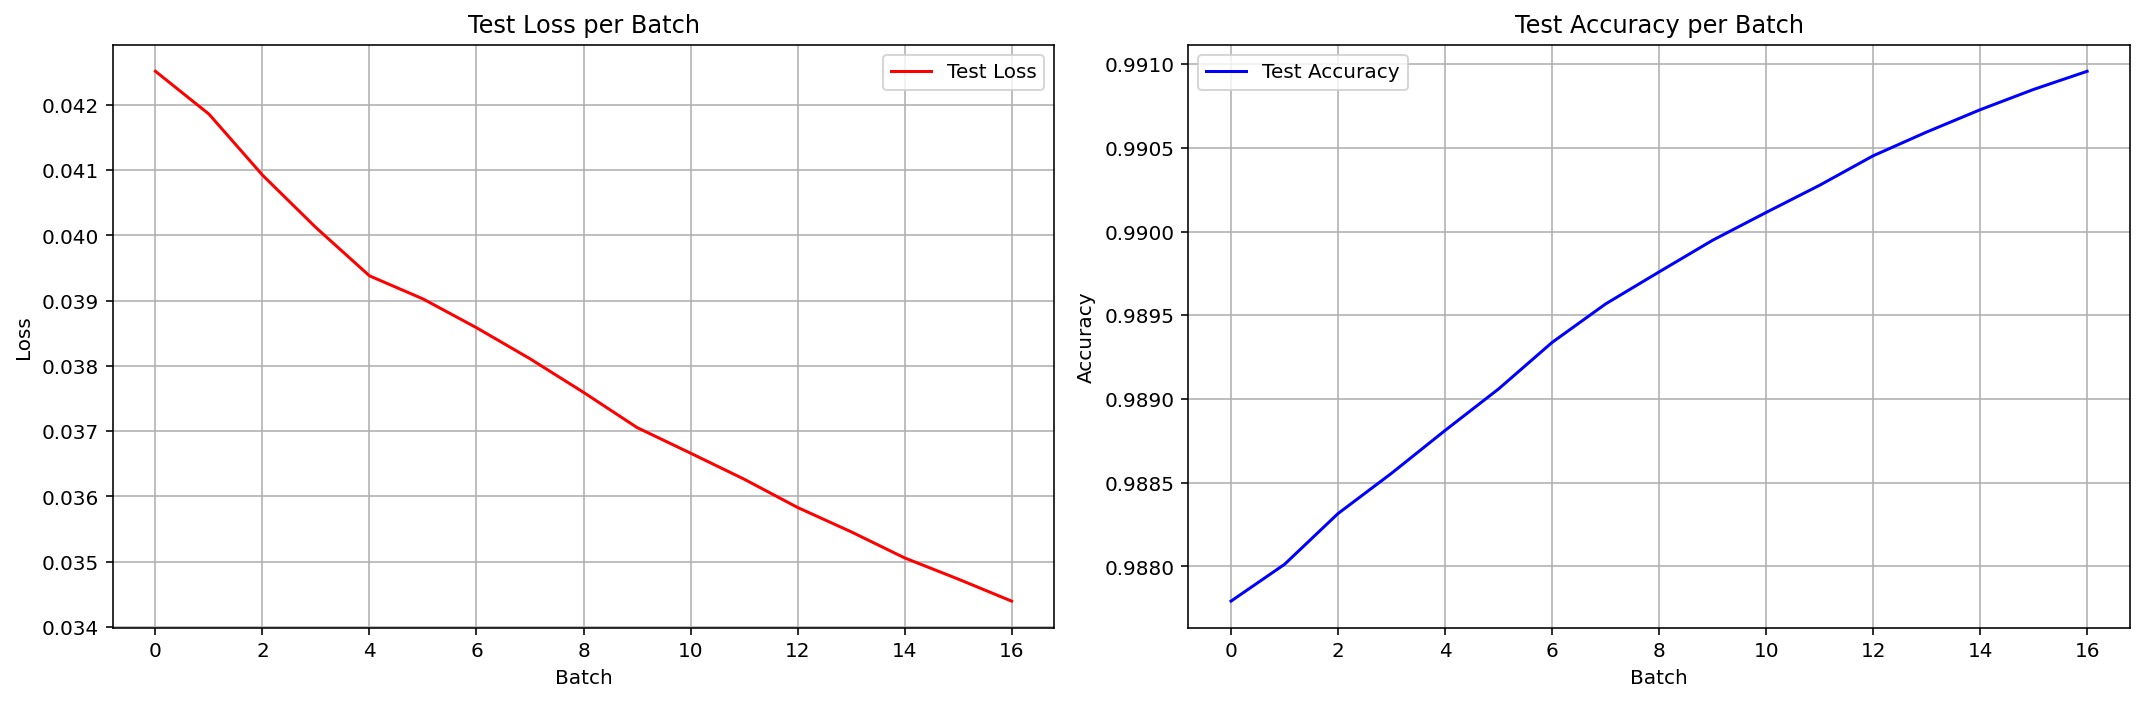

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Test Loss
ax1.plot(loss, label='Test Loss', color='red')
ax1.set_xlabel('Batch')
ax1.set_ylabel('Loss')
ax1.set_title('Test Loss per Batch')
ax1.legend()
ax1.grid(True)

# Plot Test Accuracy
ax2.plot(accuracy, label='Test Accuracy', color='blue')
ax2.set_xlabel('Batch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Test Accuracy per Batch')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### Explanation of Results

**Loss Reduction:** The left graph shows a steady decline in test loss from approximately ~0.04 to ~0.035 over 16 batches. This consistent downward trend indicates the model is successfully minimizing its prediction errors during training.

**Accuracy Improvement:** The right graph demonstrates corresponding improvement in test accuracy, rising from about ~98.8% to ~99.1% - a meaningful gain of roughly 0.3 percentage points.

This is a generally healthy learning pattern, both metrics are moving in the expected directions. While the final metrics seem impressive (a low loss of 0.03 and a high accuracy of 0.99), they can be attributed to the fact that the Gemma3_1B model comes with substantial advantages from its pre-training phase, having developed general language understanding from training on a massive corpus, and the additional instruction tuning checkpoints further enhances performance by aligning the model to follow specific task instructions effectively and improving generalization across different language tasks.

The `tiny_shakespeare` dataset has limited complexity, a small scale of just 1 MiB, and a well-defined literary domain, so the model could quickly adapt its pre-trained knowledge without requiring extensive computational resources. The writing also follows consistent patterns that a sophisticated language model can readily learn. This explains the high initial accuracy on the testing set and steady improvement.

**Overall, Jaxloop provides an easy-to-use solution for training and fine tuning various Transformer models, most notably the Gemma3 Transformers. The pipeline includes a data preprocessor, data loader, and the TransformerStep. All components have default configurations, but can also be customized (as demonstrated in this Colab) per model requirements.**